In [1]:
import re
from pprint import pprint

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import spacy
from gensim.models import KeyedVectors, Word2Vec
from nltk.corpus import stopwords
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity


pd.set_option('display.max_colwidth', None)
SPECIAL_CHARS = '[^A-Za-z0-9 ]+'
STOP_WORDS = stopwords.words('english')

# 2. Functions

In [2]:
def preprocess_text(text):
    """
    Take out stopwords.
    Take out punctuations and special characters.
    """
    SPECIAL_CHARS = '[^A-Za-z0-9 ]+'
    STOP_WORDS = stopwords.words('english')
    text = text.lower().split(' ')
    temp = [word for word in text if word not in STOP_WORDS]
    text = ' '.join(temp)
    text = re.sub(SPECIAL_CHARS, '', text)
    return text

In [3]:
def tokenise(doc):
    return [token.text for token in nlp(doc)]

In [4]:
def tokenise_lemma(doc):
    """
    Use spacy as the nlp object to tokenise each doc
    Lemmatise each words
    """
    return ' '.join([token.lemma_ for token in nlp(doc)])

In [5]:
# this is one way to get each title's vector representation
# more investagtion is needed later.

def get_vectors(first_map, second_map):
    """
    Use tokenised words to get vectors representations from the pretrained model (i.e. second_map).
    Average the vector representation of the description as the representation of the document 
    (i.e. each movie title's representation is the mean of vectors of each words in its description)
    """
    first_vec  = dict()
    for title, description in first_map.items():
        temp = list()
        for element in description: #element = tokenised words
            try:
                temp.append(second_map[element]) #secondmap is w2v model which should have a responding word vecotr for the tokenise word
            except KeyError:
                pass
        first_vec[title] = np.mean(temp, axis=0)
    
    return first_vec

In [6]:
def search(name, df):
    return df.loc[df['title'].str.lower()==name.lower()]

In [31]:
def get_topN_similar(lookup_id, title_vec, df, N=10):
    lookup_id = lookup_id.lower()
    sim = list()
    lookup_map = title_vec
    subject_map = title_vec 
        
    for uid, vec in lookup_map.items():
        thisSim = cosine_similarity(vec.reshape(1, -1), subject_map[lookup_id].reshape(1, -1))
        org = search(uid, df).originals.values
        gen = search(uid, df).genres.values
        sim.append((uid, thisSim[0][0], org, gen))
    sim = sorted(sim, key=lambda x: x[1], reverse=True)[:N+1]
    returnDf = pd.DataFrame(columns=['title','similarity','originals','genres'],
                           data = sim)
    return returnDf

In [8]:
def get_most_similar(lookup_id, title_vec, df):

    sim = list()
    lookup_map = title_vec
    subject_map = title_vec 
        
    for uid, vec in lookup_map.items():
        thisSim = cosine_similarity(vec.reshape(1, -1), subject_map[lookup_id].reshape(1, -1))
        org = search(uid, df).originals.values
        gen = search(uid, df).genres.values
        sim.append((uid, thisSim[0][0], org, gen))

    return sorted(sim, key=lambda x: x[1], reverse=True)

In [9]:
def filter_df(keyword):
    """
    Return a dataframe with the filtered result.
    The input value is case-insensitive. 
    """
    if type(keyword) == list:
        return netflixDf.loc[netflixDf['title'].isin(keyword)]
    else:
        return netflixDf.loc[netflixDf['title'].str.lower().isin([keyword.lower()])]

In [10]:
def markerX(key, values):
    return netflixDf.loc[netflixDf[key].str.lower().isin(values)].sort_values(by='pca_2', ascending=False)

def others(key, values):
    return netflixDf.loc[~netflixDf[key].str.lower().isin(values)]

# 3. Analyse Pipeline

## Terms explained
Document -> a bunch of texts <br>
Corpus -> a bunch of documents <br>
Vectors -> a mathematically convenience representation of a document (a bunch of textx) <br>
Models -> an algorithm for transforming vectors from one representation to another <br>

## Read the dataset/ Load the spacy pretrained model

In [87]:
netflixDf = pd.read_csv('finalDataset_v2.csv', usecols=['title','type','description','genres','originals', 'year'])

In [88]:
df = pd.read_csv('debugged.csv', usecols=['cleaned'])

In [89]:
netflixDf = pd.concat([netflixDf,df], axis=1)

In [14]:
# np.where(pd.isnull(df.cleaned))

In [15]:
# use pre-trained corpus to help tokenise words
nlp = spacy.load('en_core_web_sm')

## Analyse Descriptive Data

In [63]:
movieDf = netflixDf.loc[netflixDf['type']=='movie']
tvshowDf = netflixDf.loc[netflixDf['type']=='tvshow']

## Create Corpus and apply word embedding

In [64]:
movieCorpus = movieDf.cleaned.values.tolist() #list of docs
tvshowCorpus = tvshowDf.cleaned.values.tolist() #list of docs

In [65]:
movieTkDocs = [tokenise(doc) for doc in movieCorpus] #tokenise 
tvshowTkDocs = [tokenise(doc) for doc in tvshowCorpus] #tokenise 

In [66]:
# mapping out the title and each description. so later on i can search 
movieMap = dict(zip(movieDf['title'].str.lower().tolist(), movieTkDocs))
tvshowMap = dict(zip(tvshowDf['title'].str.lower().tolist(), tvshowTkDocs))
# lower the title (easy for search)

In [21]:
path = "GoogleNews-vectors-negative300.bin"
w2v = KeyedVectors.load_word2vec_format(path, binary=True)
# It is much faster take less than 2 minutes

In [67]:
movieTitleVec = get_vectors(movieMap, w2v)

In [68]:
tvshowTitleVec = get_vectors(tvshowMap, w2v)

In [26]:
get_topN_similar('you', tvshowTitleVec, tvshowDf)

,title,similarity,originals,genres
0,you,1.000000,[0],"[crime,drama,romance,thriller]"
1,man down,0.851182,[0],[comedy]
2,sword art online alternative: gun gale online,0.850906,[0],"[animation,anime,action-and-adventure,fantasy,science-fiction]"
3,love alarm,0.843957,[1],"[drama,comedy,romance]"
4,the mysteries of laura,0.832644,[0],"[comedy,crime,drama,mystery]"
5,"love, chunibyo & other delusions",0.832444,[0],"[animation,anime,comedy,drama,romance,fantasy]"
6,no tomorrow,0.828042,[0],"[drama,comedy,romance]"
7,the good place,0.827645,[0],"[comedy,drama,fantasy,romance,science-fiction]"
8,london spy,0.825912,[0],"[drama,lgbtq,crime,mystery,romance,thriller]"
9,servant of the people,0.825141,[0],[comedy]


In [69]:
search('splatter',movieDf)

,title,genres,description,type,originals,cleaned
2819,Splatter,"horror,drama",https://www.themoviedb.org/tv/39633-splatterSplatter is streaming with subscription on Netflix. It's a drama and horror movie with a very low IMDb audience rating of 3.1 (456 votes).,movie,0,"Johnny Splatter accumulated as many hit records as he did enemies on his climb up the fame ladder. His sudden death, ruled a suicide, brings a small circle of professional parasites and hangers-on to his Hollywood Hills mansion for the reading of his last will and testament. But as his “frenemies” come to pick the bones clean, Johnny has returned for a deadly encore long after what they thought was his final curtain."


In [70]:
x = movieTitleVec['splatter']
y = movieTitleVec['tall girl']
cosine_similarity(x.reshape(1, -1), y.reshape(1, -1))

array([[0.79452443]], dtype=float32)

In [56]:
def get_topN_similar(lookup_id, title_vec, df, N=10):
    lookup_id = lookup_id.lower()
    sim = list()
    lookup_map = title_vec
    subject_map = title_vec 
        
    for uid, vec in lookup_map.items():
        try:
            thisSim = cosine_similarity(vec.reshape(1, -1), subject_map[lookup_id].reshape(1, -1))
            org = search(uid, df).originals.values
            gen = search(uid, df).genres.values
            sim.append((uid, thisSim[0][0], org, gen))
        except:
            print(uid)
    sim = sorted(sim, key=lambda x: x[1], reverse=True)[:N+1]
    returnDf = pd.DataFrame(columns=['title','similarity','originals','genres'],
                           data = sim)
    return returnDf

In [72]:
get_topN_similar('The Perfect Date', movieTitleVec, movieDf)

,title,similarity,originals,genres
0,the perfect date,1.000000,[1],"[romance,comedy]"
1,my birthday song,0.788607,[0],[thriller]
2,swiped,0.783935,[0],"[comedy,romance,drama]"
3,social animals,0.780966,[0],"[documentary,comedy,romance]"
4,yes or no,0.780705,[0],"[comedy,romance]"
5,kaake da viyah,0.777043,[0],"[comedy,romance]"
6,kicking and screaming,0.777026,[0],"[comedy,drama,romance]"
7,68 kill,0.776625,[0],"[comedy,romance,thriller,crime,mystery]"
8,can't hardly wait,0.776468,[0],"[comedy,romance,drama]"
9,french dirty,0.775756,[0],"[comedy,drama]"


In [150]:
get_topN_similar('The Perfect Date', movieTitleVec, mvevt)

,title,similarity,originals,genres
0,the perfect date,1.000000,[1],"[romance,comedy]"
1,swiped,0.821608,[0],"[comedy,romance,drama]"
2,yes or no,0.810153,[0],"[comedy,romance]"
3,lady-like,0.809170,[0],"[comedy,romance]"
4,can't hardly wait,0.807135,[0],"[comedy,romance,drama]"
5,social animals,0.806844,[0],"[documentary,comedy,romance]"
6,#friendbutmarried,0.805303,[0],"[biography,drama,romance,comedy]"
7,68 kill,0.802554,[0],"[comedy,romance,thriller,crime,mystery]"
8,the new romantic,0.801927,[0],"[drama,comedy,romance]"
9,yes or no 2.5,0.800287,[0],"[romance,comedy]"


In [54]:
for key, value in movieTitleVec.items():
    if np.isfinite(value.all()) == False:
        print(key)

## What if I include genre information

In [123]:
movieDf_gen = netflixDf.loc[netflixDf['type']=='movie'].copy()

In [90]:
# netflixDf['genres'].fillna('No info', inplace=True)

In [109]:
y = []
for i in netflixDf.year.values.tolist():
    if len(i)==4:
        y.append(i)
    else:
        y.append('No info')

In [112]:
netflixDf['year'] = y

In [114]:
# netflixDf.to_csv('finaldataset_v3.csv')

In [131]:
temp = pd.read_csv('finaldataset_v3.csv', usecols=['title','genres','year','type','originals','cleaned'])
mvevt = temp.loc[temp['type']=='movie'].copy()

In [132]:
mvevt.head(1)

,title,genres,year,type,originals,cleaned
0,1000 Mabrouk,"comedy,drama,fantasy,thriller",2009,movie,0,"About a man who wakes up one morning to discover that the day repeats, a carbon copy of the day before, trapping him in an inescapable vicious circle. This man has a dream to live for 100 years, however he is living for one day only and that day keep repeating to show him the negative and positive things in his life."


In [135]:
mvevt['genres'].isnull().sum()

0

In [138]:
everything = list()
for ix in range(3770):
    everything.append(mvevt.iloc[ix,5]+ ' ' +mvevt.iloc[ix,1])
    

In [139]:
everything[0]

'About a man who wakes up one morning to discover that the day repeats, a carbon copy of the day before, trapping him in an inescapable vicious circle. This man has a dream to live for 100 years, however he is living for one day only and that day keep repeating to show him the negative and positive things in his life. comedy,drama,fantasy,thriller'

In [140]:
mvevt['everything'] = everything

In [144]:
mvevtTkDocs = [tokenise(doc) for doc in mvevt.everything.values.tolist()] #tokenise 

In [145]:
# mapping out the title and each description. so later on i can search 
movieMap = dict(zip(mvevt['title'].str.lower().tolist(), mvevtTkDocs))
# lower the title (easy for search)

In [146]:
movieTitleVec = get_vectors(movieMap, w2v)

In [149]:
get_topN_similar('tall girl', movieTitleVec, mvevt)

,title,similarity,originals,genres
0,tall girl,1.000000,[1],"[comedy,drama,romance]"
1,laggies,0.889598,[0],"[comedy,romance,drama]"
2,love is blind,0.888021,[1],"[comedy,drama,romance]"
3,social animals,0.873785,[0],"[documentary,comedy,romance]"
4,ugly aur pagli,0.872610,[0],"[comedy,drama,romance]"
5,next enti?,0.871522,[0],"[comedy,drama,romance]"
6,deliha 2,0.867681,[0],[comedy]
7,isoken,0.867054,[0],[romance]
8,rainbow time,0.864650,[0],"[comedy,drama]"
9,jessica darling's it list,0.864558,[0],[family]


## It is clear that adding genres into corpus improves accuracy

# Descriptive analysis

In [151]:
# genres count
mv = temp.loc[temp['type']=='movie'].copy()

In [158]:
from collections import defaultdict

In [167]:
genres_count = defaultdict(int)
mv_gen_list = mv.genres.values.tolist()
for movie in mv_gen_list:
    for genre in movie.split(','):
        genres_count[genre] += 1
    

In [168]:
genres_count

defaultdict(int,
            {'comedy': 1489,
             'drama': 1779,
             'fantasy': 296,
             'thriller': 795,
             'documentary': 628,
             'biography': 201,
             'action-and-adventure': 824,
             'romance': 678,
             'horror': 291,
             'sport': 105,
             'crime': 441,
             'mystery': 650,
             'history': 168,
             'musical': 162,
             'science-fiction': 215,
             'No info': 116,
             'lgbtq': 46,
             'family': 408,
             'animation': 240,
             'cult': 17,
             'stand-up-and-talk': 204,
             'anime': 47,
             'food': 5,
             'independent': 13,
             'children': 14,
             'travel': 3,
             'reality': 1})

In [185]:
genres_df = pd.DataFrame(data = [genres_count])

In [186]:
genres_df = genres_df.transpose().reset_index().rename(columns={'index':'genres',0:'counts'}).sort_values(by = 'counts', ascending=False)

In [192]:
genres_df.head()

,genres,counts
0,drama,1779
1,comedy,1489
2,action-and-adventure,824
3,thriller,795
4,romance,678


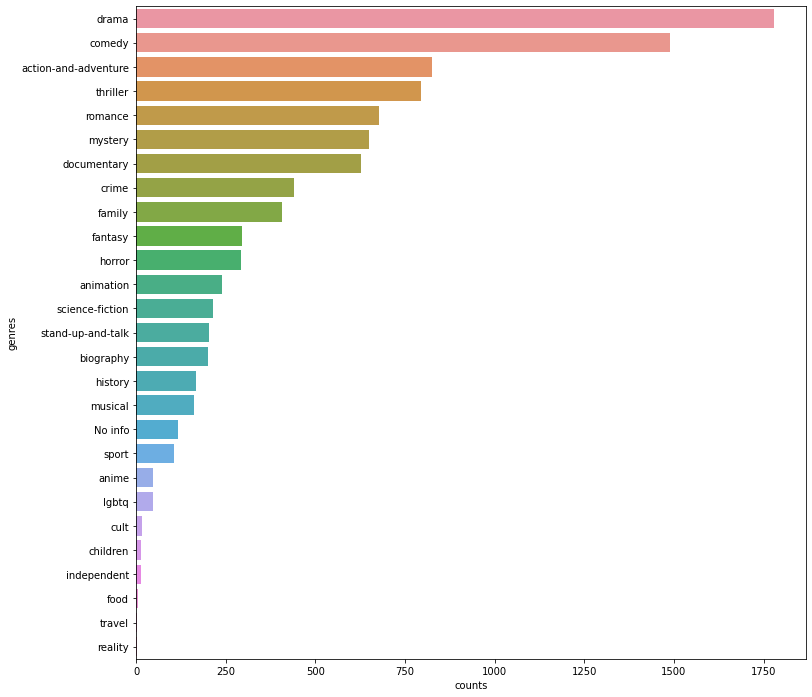

In [211]:
fig, ax = plt.subplots(figsize=(12,12))
genres = genres_df.genres.values.tolist()
bar = sns.barplot(x = 'counts',
                  y = 'genres',
                  data = genres_df,
                  ax = ax,
                  orient = 'h')
# bar.set_xticklabels(bar.get_xticklabels(), rotation=90, horizontalalignment='right', size=14)
plt.show()